In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def load_kitti_calib(calib_file):
    with open(calib_file, 'r') as f:
        calib_lines = f.readlines()
    calib_dict = {}
    for line in calib_lines:
        key = line.split(':')[0]
        calib_dict[key] = np.array([float(x) for x in line.strip().split(' ')[1:]])
    return calib_dict

def compute_bev_to_image_homography(P2, R0, Tr_velo_to_cam):
    R0_4x4 = np.eye(4)
    R0_4x4[:3, :3] = R0

    Tr_velo_to_cam_4x4 = np.eye(4)
    Tr_velo_to_cam_4x4[:3, :] = Tr_velo_to_cam

    # Transformation from BEV (Lidar ground plane) to image
    T = P2 @ R0_4x4 @ Tr_velo_to_cam_4x4
    
    # Project to 2D by setting Z = 0
    T[:, 2] = 0  # Zero out Z-component
    H_bev2img = T[:, [0,1,3]]  # Keep only X, Y, and bias
    return H_bev2img

In [77]:
calib_file = "data/calib/um_000000.txt"
calib_dict = load_kitti_calib(calib_file)

P2 = calib_dict['P2'].reshape((3, 4))
R0_rect = calib_dict['R0_rect'].reshape((3, 3))
Tcr = calib_dict['Tr_cam_to_road'].reshape((3, 4))

H_bev2img = compute_bev_to_image_homography(P2, R0_rect, Tcr)

H_img2bev = np.linalg.inv(H_bev2img)

In [105]:
img = cv2.imread(f"results/sUNetWide_v8_Srop_adam/um_000006.png", cv2.COLOR_BGR2RGB)
H, W = img.shape

# img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# img_bgra = np.concatenate((img_bgr, 255 * np.ones((*img_bgr.shape[:2], 1), dtype=img_bgr.dtype)), axis=-1)

bev_img = cv2.warpPerspective(img, H_img2bev, (W, H), flags=cv2.INTER_LINEAR)

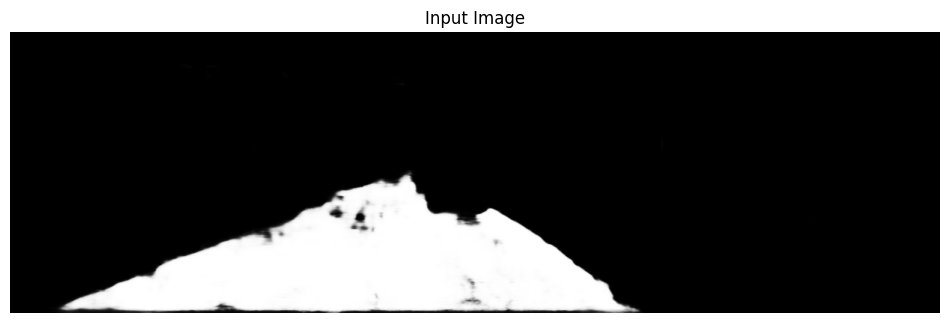

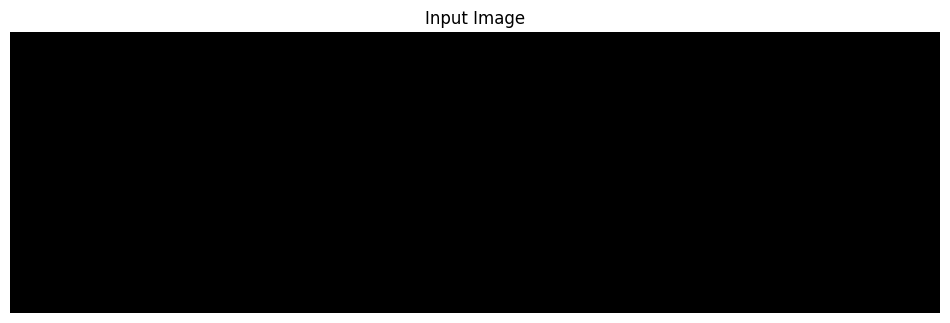

In [106]:
plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.figure(figsize=(12, 6))
plt.imshow(bev_img, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.show()

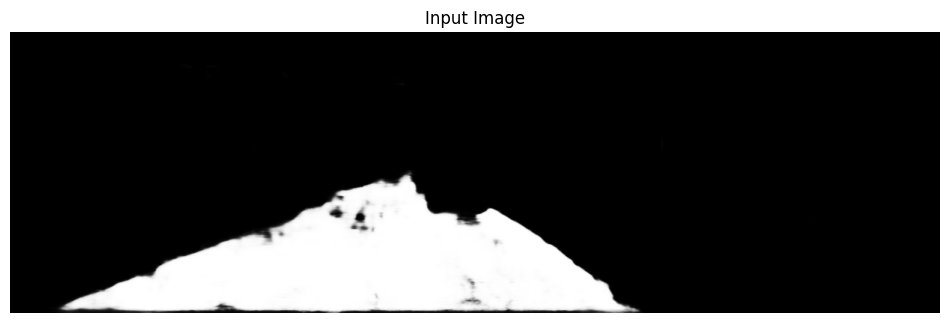

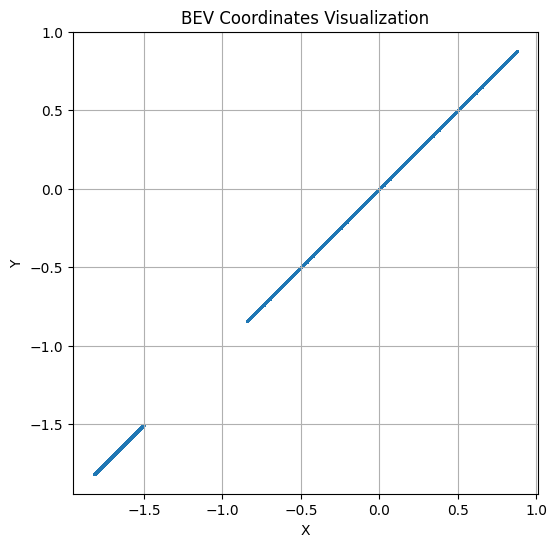

In [45]:
img = cv2.imread(f"results/sUNetWide_v8_Srop_adam/um_000006.png", cv2.IMREAD_UNCHANGED)

# Convert grayscale image to BGR and add alpha channel
img_bgr = cv2.cvtColor(255 * img, cv2.COLOR_GRAY2BGR)
img_bgra = np.concatenate((img_bgr, 255 * np.ones((*img_bgr.shape[:2], 1), dtype=img_bgr.dtype)), axis=-1)
H, W, _ = img_bgra.shape

# Prepare pixel grid in homogeneous coordinates
ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
pixels_hom = np.stack([xs.flatten(), ys.flatten(), np.ones(H * W)], axis=0)  # shape (3, H*W)
pixels_hom = np.vstack([pixels_hom, np.ones((1, H * W))])  # shape (4, H*W)

# Backproject to camera coordinates
P0_inv = np.linalg.inv(P0_44)
rays_cam = P0_inv @ pixels_hom
rays_cam /= rays_cam[3, :]

# Transform to road (BEV) frame
rays_bev = Tcr_44 @ rays_cam
# rays_bev = rays_cam

# Extract BEV coordinates
bev_coords = rays_bev[:2, :].T.reshape(W, H, 2)

plt.figure(figsize=(12, 6))
plt.imshow(img, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Get pixel locations where intensity is greater than 200
pixel_locs = np.column_stack(np.where(img > 200))

plt.figure(figsize=(6, 6))
plt.scatter(bev_coords[pixel_locs, 0].flatten(), bev_coords[pixel_locs, 1].flatten(), s=1, alpha=0.5)
plt.title("BEV Coordinates Visualization")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.show()